## In this notebook, we will cover:
- [Overview](#0) \
<br/>
- [Importing Libraries](#1) \
<br/>
- [Loading Dataset](#2) \
<br/>
- [Exploratory Data Analysis (EDA)](#3) \
<br/>
- [Cross Validation](#4) \
<br/>
- [XGBoost](#5)

## Overview <a name="0"> </a>

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

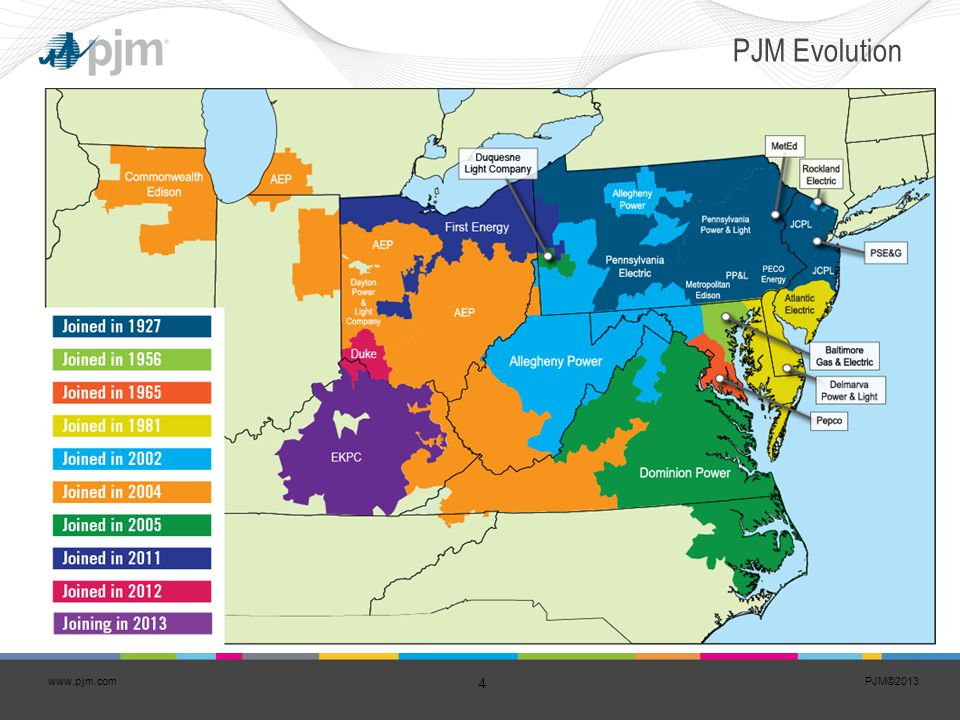

In [5]:
import requests
import IPython.display as Disp

url = 'http://slideplayer.com/4238181/14/images/4/PJM+Evolution.jpg'
Disp.Image(requests.get(url).content)

# Importing Libraries <a name="1"> </a>

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Loading Dataset <a name="2"> </a>

In [7]:
df = pd.read_csv('.data/PJME_hourly.csv')

Sort by Datetime

In [8]:
sorted_df = df.sort_values(by='Datetime')
sorted_df = sorted_df.reset_index(drop=True)

In [9]:
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


Check for missing values

In [10]:
null_count = sorted_df.isnull().sum()
print(null_count)

Datetime    0
PJME_MW     0
dtype: int64


Check for duplicate rows

In [11]:
duplicate_rows = sorted_df[sorted_df.duplicated(subset=['Datetime'], keep=False)]
print(duplicate_rows)

                   Datetime  PJME_MW
112487  2014-11-02 02:00:00  23755.0
112488  2014-11-02 02:00:00  22935.0
121223  2015-11-01 02:00:00  21567.0
121224  2015-11-01 02:00:00  21171.0
130127  2016-11-06 02:00:00  20795.0
130128  2016-11-06 02:00:00  21692.0
138863  2017-11-05 02:00:00  21236.0
138864  2017-11-05 02:00:00  20666.0


In [12]:
number_of_duplicate_rows = sorted_df.duplicated('Datetime', keep=False).sum()
print("Total number of duplicate rows based on 'Datetime'")
print (number_of_duplicate_rows)

Total number of duplicate rows based on 'Datetime'
8


Handle the duplicate rows

In [13]:
print(sorted_df.iloc[112482:112494]) #print the previous 5 and next 5 values of the duplicates rows

                   Datetime  PJME_MW
112482  2014-11-01 21:00:00  29695.0
112483  2014-11-01 22:00:00  28829.0
112484  2014-11-01 23:00:00  27430.0
112485  2014-11-02 00:00:00  25838.0
112486  2014-11-02 01:00:00  23538.0
112487  2014-11-02 02:00:00  23755.0
112488  2014-11-02 02:00:00  22935.0
112489  2014-11-02 03:00:00  22789.0
112490  2014-11-02 04:00:00  22555.0
112491  2014-11-02 05:00:00  23247.0
112492  2014-11-02 06:00:00  23733.0
112493  2014-11-02 07:00:00  24716.0


In [ ]:
print(sorted_df.iloc[121218:121230])

In [ ]:
print(sorted_df.iloc[130122:130134])

In [ ]:
print(sorted_df.iloc[138858:138870])

Decision: Find the mean of the duplicate rows. Although the number of duplicate rows isn't significant compared to the total rows, we've decided not to keep the duplicate rows because they are due to errors in data collection and they do not reflect actual events.

In [17]:
#group duplicate rows by 'Datetime' and calculate the mean of other column
mean_duplicates = duplicate_rows.groupby('Datetime').mean().reset_index()

#create clear_df by removing duplicate rows from sorted_df
clear_df = sorted_df.drop_duplicates(subset='Datetime', keep=False)

#concatenate mean_duplicates with clear_df
clear_df = pd.concat([clear_df, mean_duplicates], ignore_index=True)

#sort clear_df by the 'Datetime' column
clear_df = clear_df.sort_values(by='Datetime').reset_index(drop=True)

clear_df #without duplicate rows

,Datetime,PJME_MW
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145357,2018-08-02 20:00:00,44057.0
145358,2018-08-02 21:00:00,43256.0
145359,2018-08-02 22:00:00,41552.0
145360,2018-08-02 23:00:00,38500.0


In [18]:
duplicate_rows2 = clear_df[clear_df.duplicated(subset=['Datetime'], keep=False)]
print(duplicate_rows2)

Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []


In [19]:
number_of_duplicate_rows2 = clear_df.duplicated('Datetime', keep=False).sum() #check if the duplicates have been removed
print("Total number of duplicate rows based on 'Datetime'")
print (number_of_duplicate_rows2)

Total number of duplicate rows based on 'Datetime'
0


Data Preparation

In [20]:
clear_df = clear_df.set_index('Datetime') #set datetime as index
clear_df.index = pd.to_datetime(clear_df.index)
clear_df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


# Exploratory Data Analysis (EDA) <a name="3"> </a>

Plotting the data

In [21]:
color_pal = sns.color_palette()

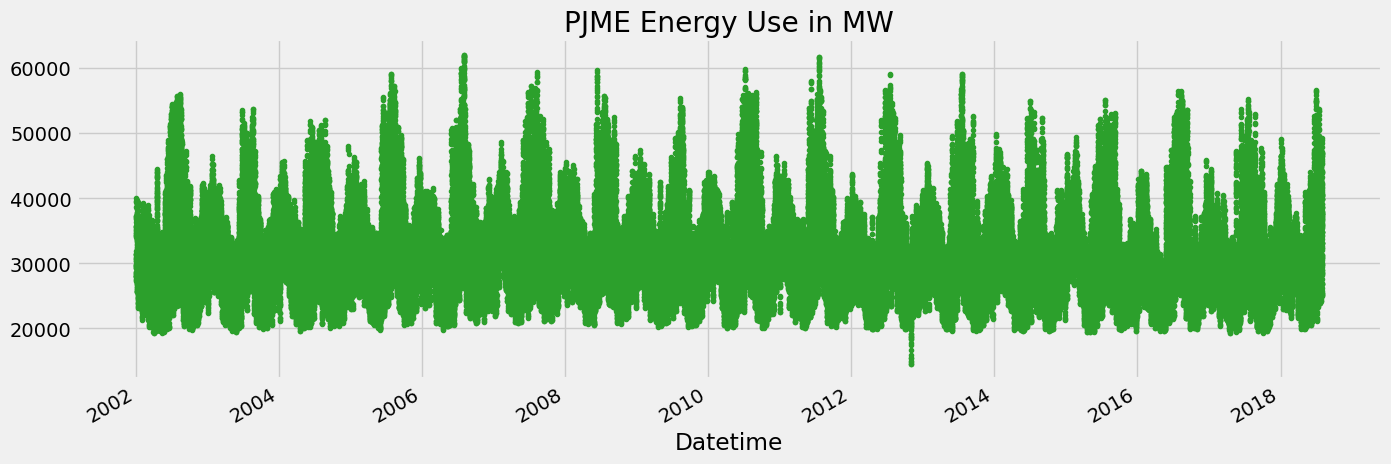

In [22]:
plt.style.use('fivethirtyeight')
clear_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[2],
        title='PJME Energy Use in MW',
        legend=False)
plt.show()

Check for outliers when MW > 60000

<Axes: xlabel='Datetime'>

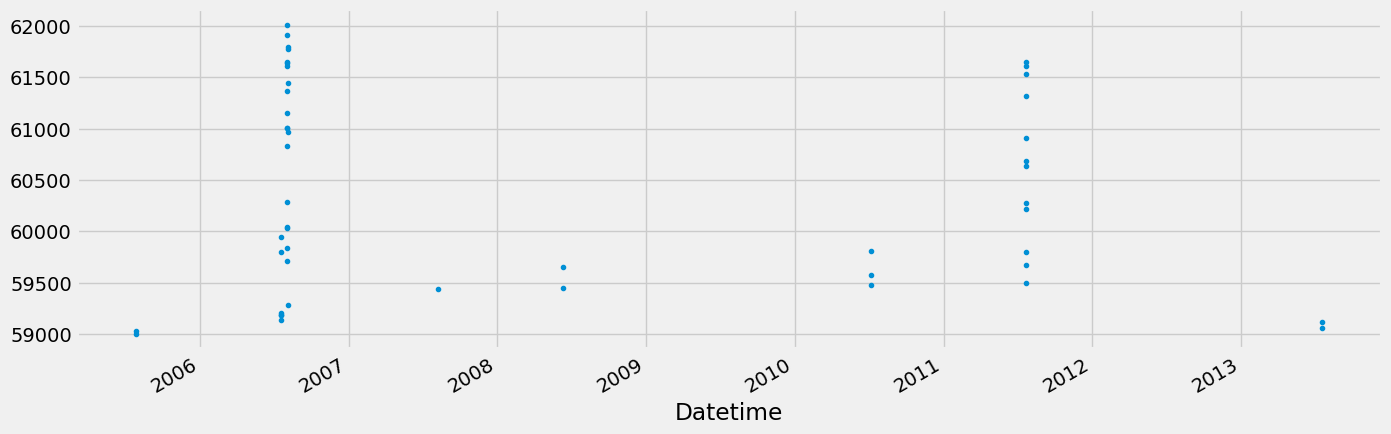

In [23]:
clear_df.query('PJME_MW > 59000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5))

Check for outliers when MW < 20000

<Axes: xlabel='Datetime'>

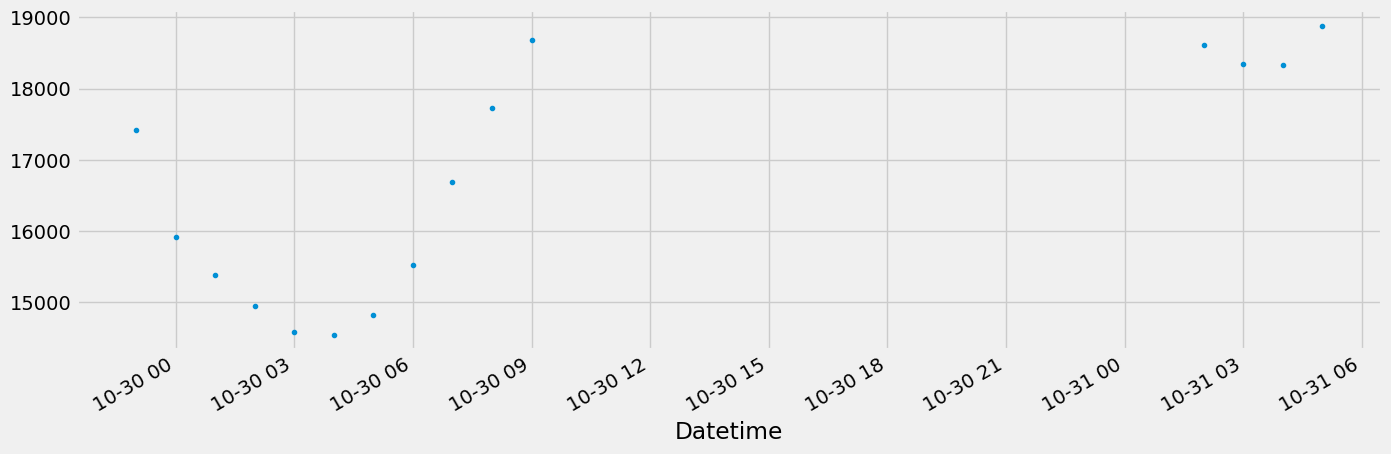

In [24]:
clear_df.query('PJME_MW < 19000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5))

Possible outliers with purple dots when MW < 19000

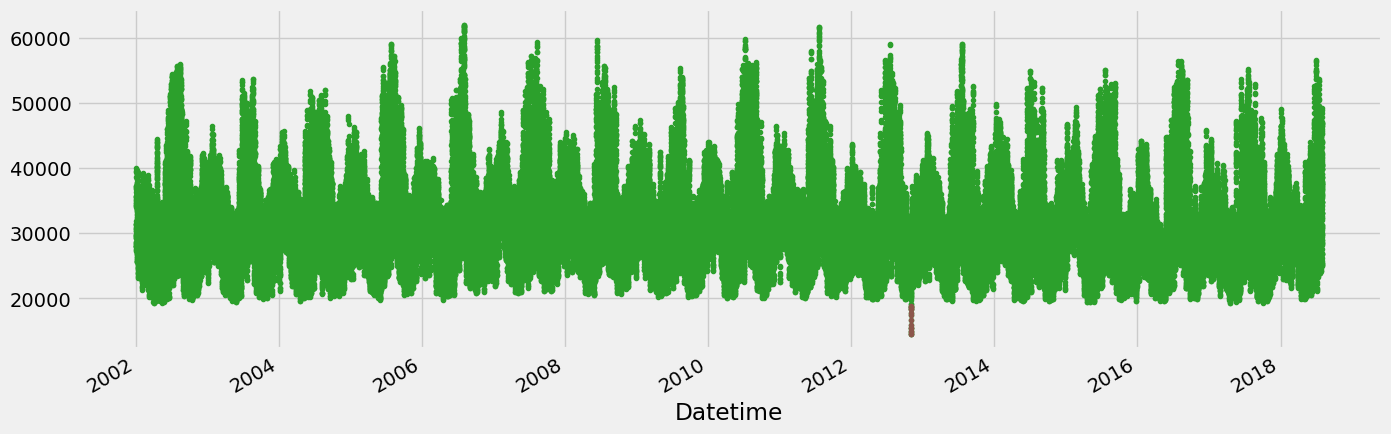

In [25]:
ax = clear_df.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[2])

clear_df.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[5],
                                             ax=ax)

ax.legend().set_visible(False)
plt.show()

Decision: Keep the outliers because they represent only 10 hours in a dataset of 145361 hours. Additionally, these 10 hours are caused by a real-life event (hurricane). We prioritize the continuity of the timeseries over the 10 hours that represent outliers.


_"On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. "_
https://en.wikipedia.org/wiki/List_of_major_power_outages#2012

Features creation

We will create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [26]:
def add_features(clear_df):

    clear_dff = clear_df.copy()
    clear_dff['hour'] = clear_dff.index.hour
    clear_dff['dayofweek'] = clear_dff.index.dayofweek
    clear_dff['quarter'] = clear_dff.index.quarter
    clear_dff['month'] = clear_dff.index.month
    clear_dff['year'] = clear_dff.index.year
    clear_dff['dayofyear'] = clear_dff.index.dayofyear
    clear_dff['dayofmonth'] = clear_dff.index.day
    clear_dff['weekofyear'] = clear_dff.index.isocalendar().week
    return clear_dff

df1 = add_features(clear_df)
df1

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


Plot new features to search for trends

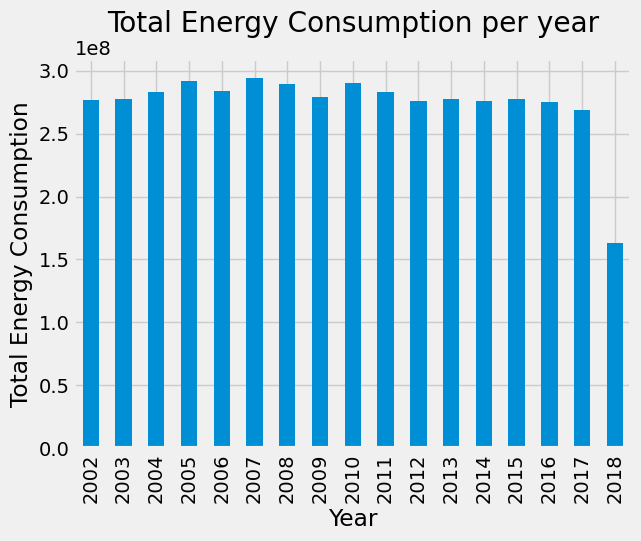

In [27]:
tyearly_energy = df1.groupby('year')['PJME_MW'].sum()
tyearly_energy.plot(kind='bar')
plt.title('Total Energy Consumption per year')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption')
plt.show()

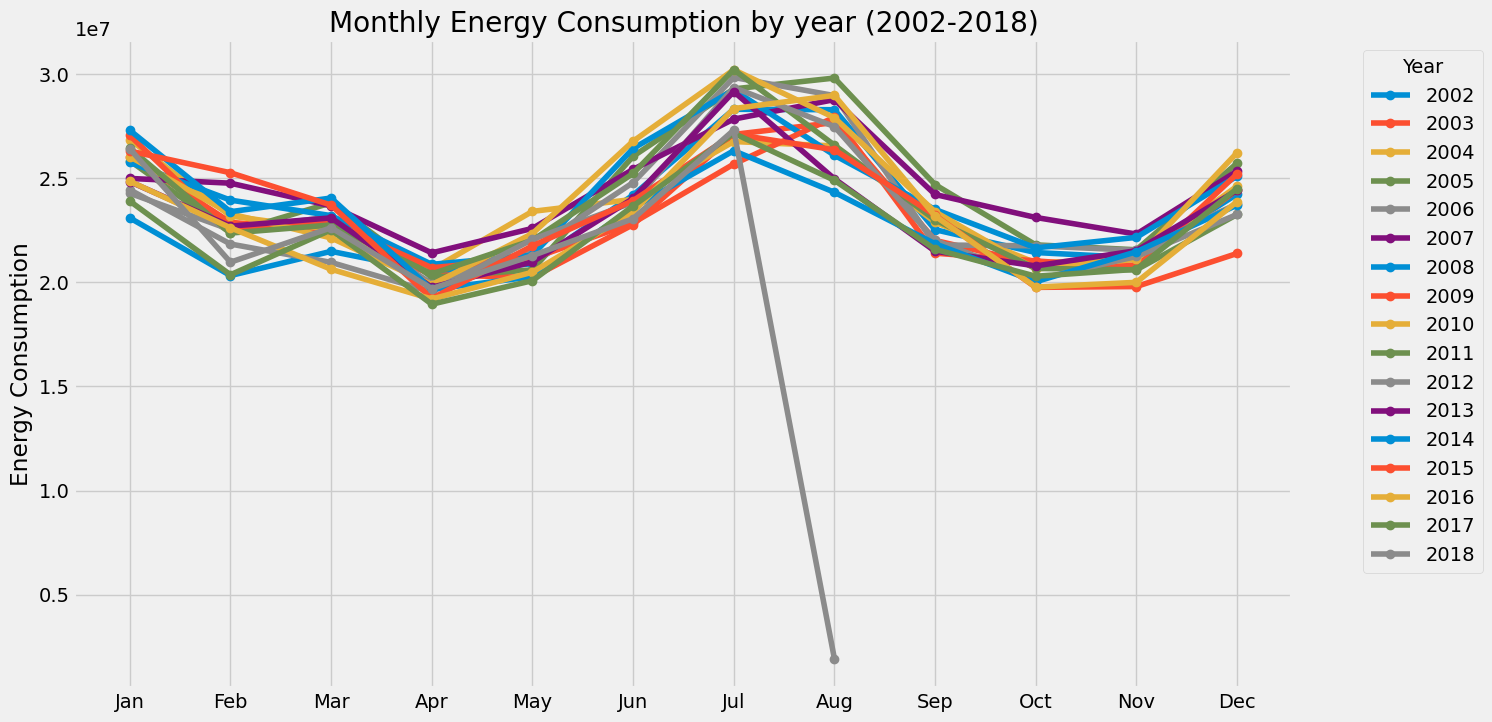

In [28]:
monthly_energy = df1.groupby(['year', 'month'])['PJME_MW'].sum().reset_index()
pivot_table = monthly_energy.pivot(index="month", columns="year", values="PJME_MW")
plt.figure(figsize=(14, 8))
for year in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[year], marker='o', label=year)
plt.title('Monthly Energy Consumption by year (2002-2018)')
plt.ylabel('Energy Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

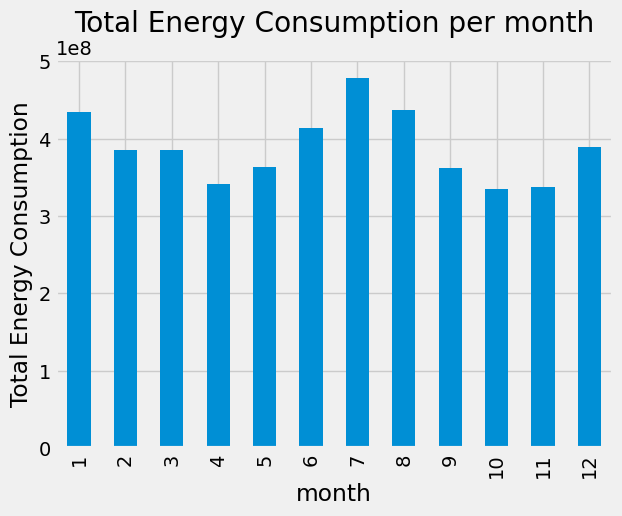

In [29]:
tmonthly_energy = df1.groupby('month')['PJME_MW'].sum()
tmonthly_energy.plot(kind='bar')
plt.title('Total Energy Consumption per month')
plt.xlabel('month')
plt.ylabel('Total Energy Consumption')
plt.show()

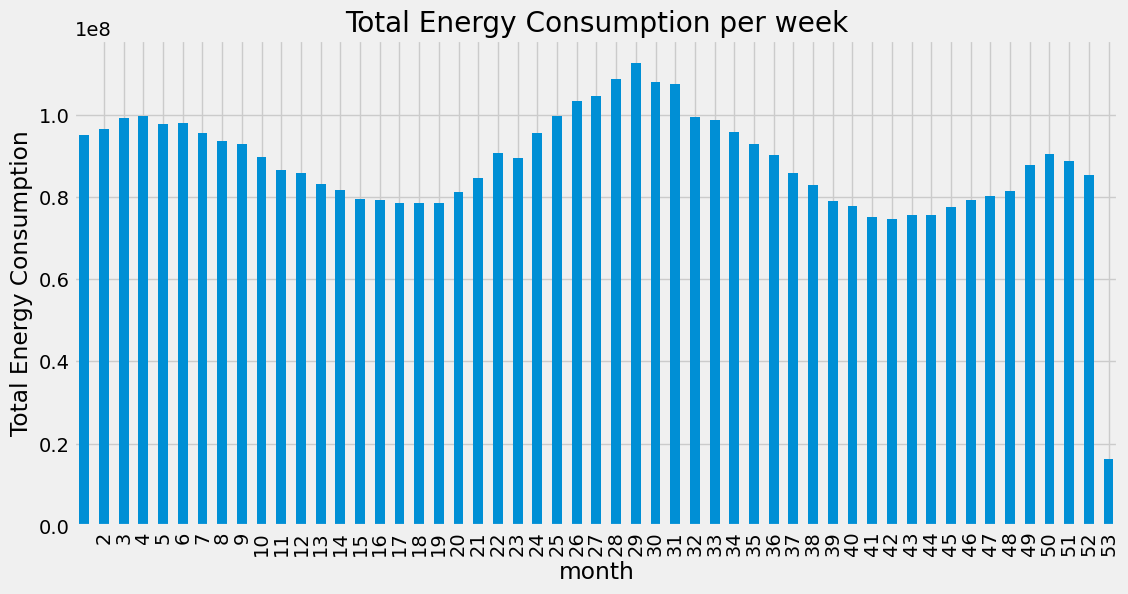

In [30]:
tyeekly_energy = df1.groupby('weekofyear')['PJME_MW'].sum()
plt.figure(figsize=(12, 6))
tyeekly_energy.plot(kind='bar')
plt.title('Total Energy Consumption per week')
plt.xlabel('month')
plt.xticks(range(1, 53))
plt.ylabel('Total Energy Consumption')
plt.show()

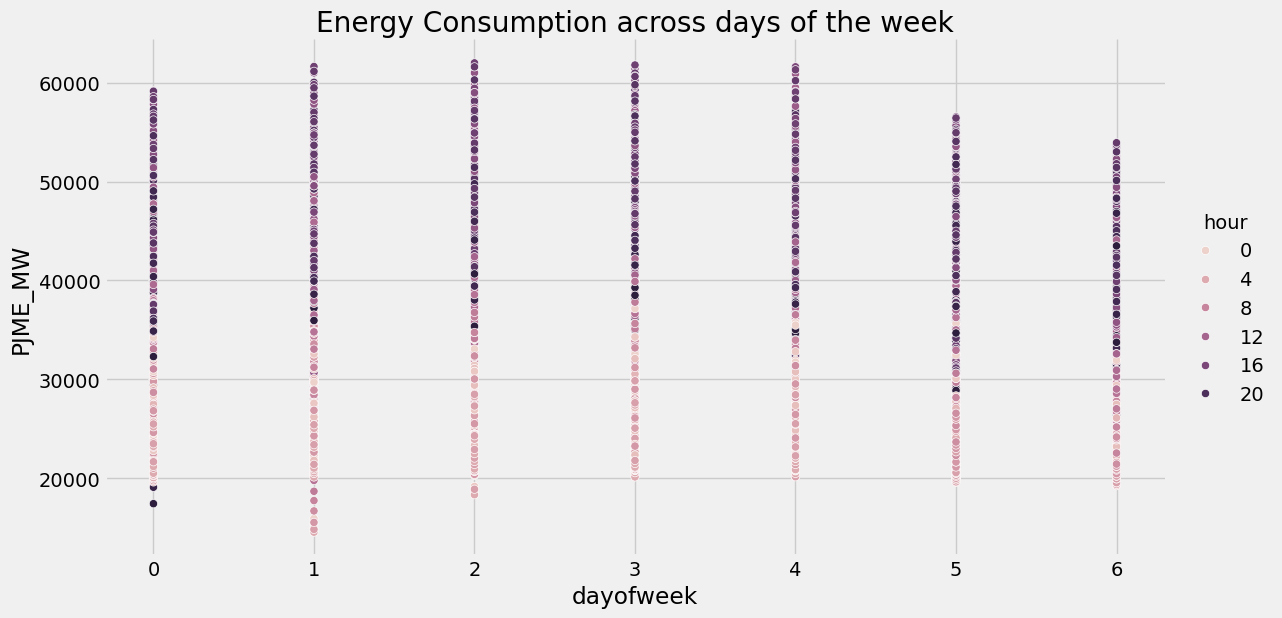

In [31]:
sns.pairplot(df1,
             hue='hour',
             x_vars=['dayofweek'], #0 is monday and 6 is sunday
             y_vars='PJME_MW',
             height=6,
             aspect=2
           )
plt.title('Energy Consumption across days of the week')
plt.show()

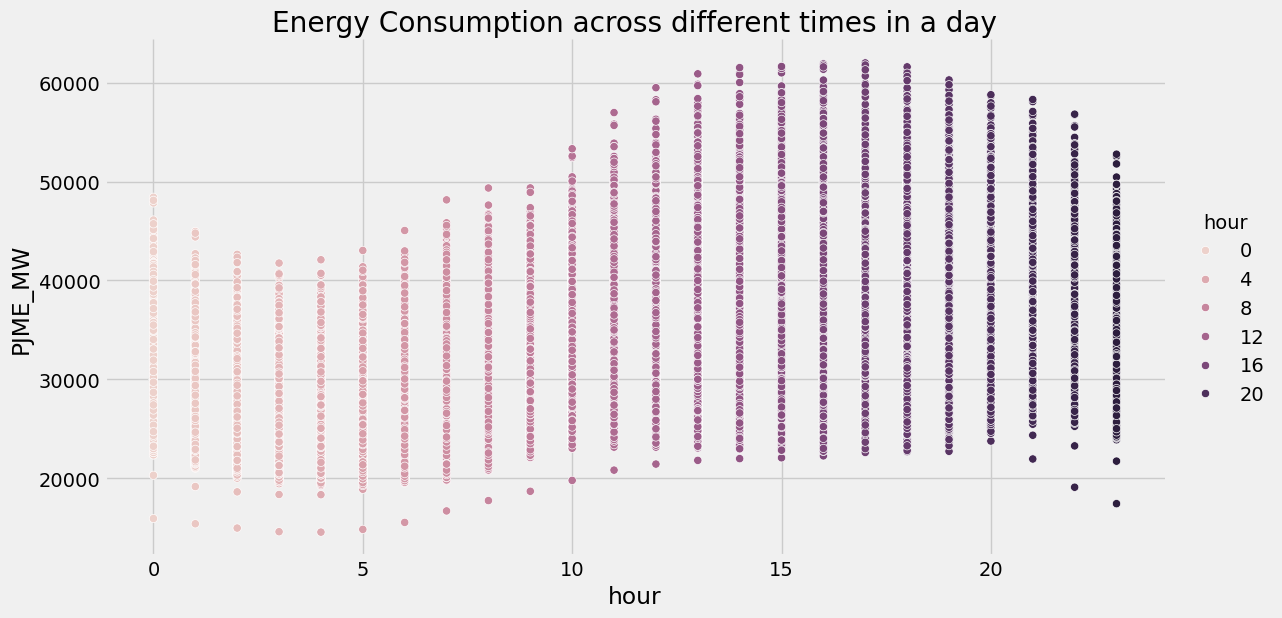

In [32]:
sns.pairplot(df1,
             hue='hour',
             x_vars=['hour'],
             y_vars='PJME_MW',
             height=6,
             aspect=2
           )
plt.title('Energy Consumption across different times in a day')
plt.show()

Key findings:

The highest Energy Consumption is during the summer (weeks 26-31). \
The daily peak Energy Consumption is around 13:00 - 19:00 in the afternoon. \
All years have about the same total consumption


## Cross Validation <a name="4"> </a>

Visualizing the training folds

In [33]:
tss = TimeSeriesSplit(n_splits = 7, test_size = 24*365*1, gap = 24)
df1 = df1.sort_index()

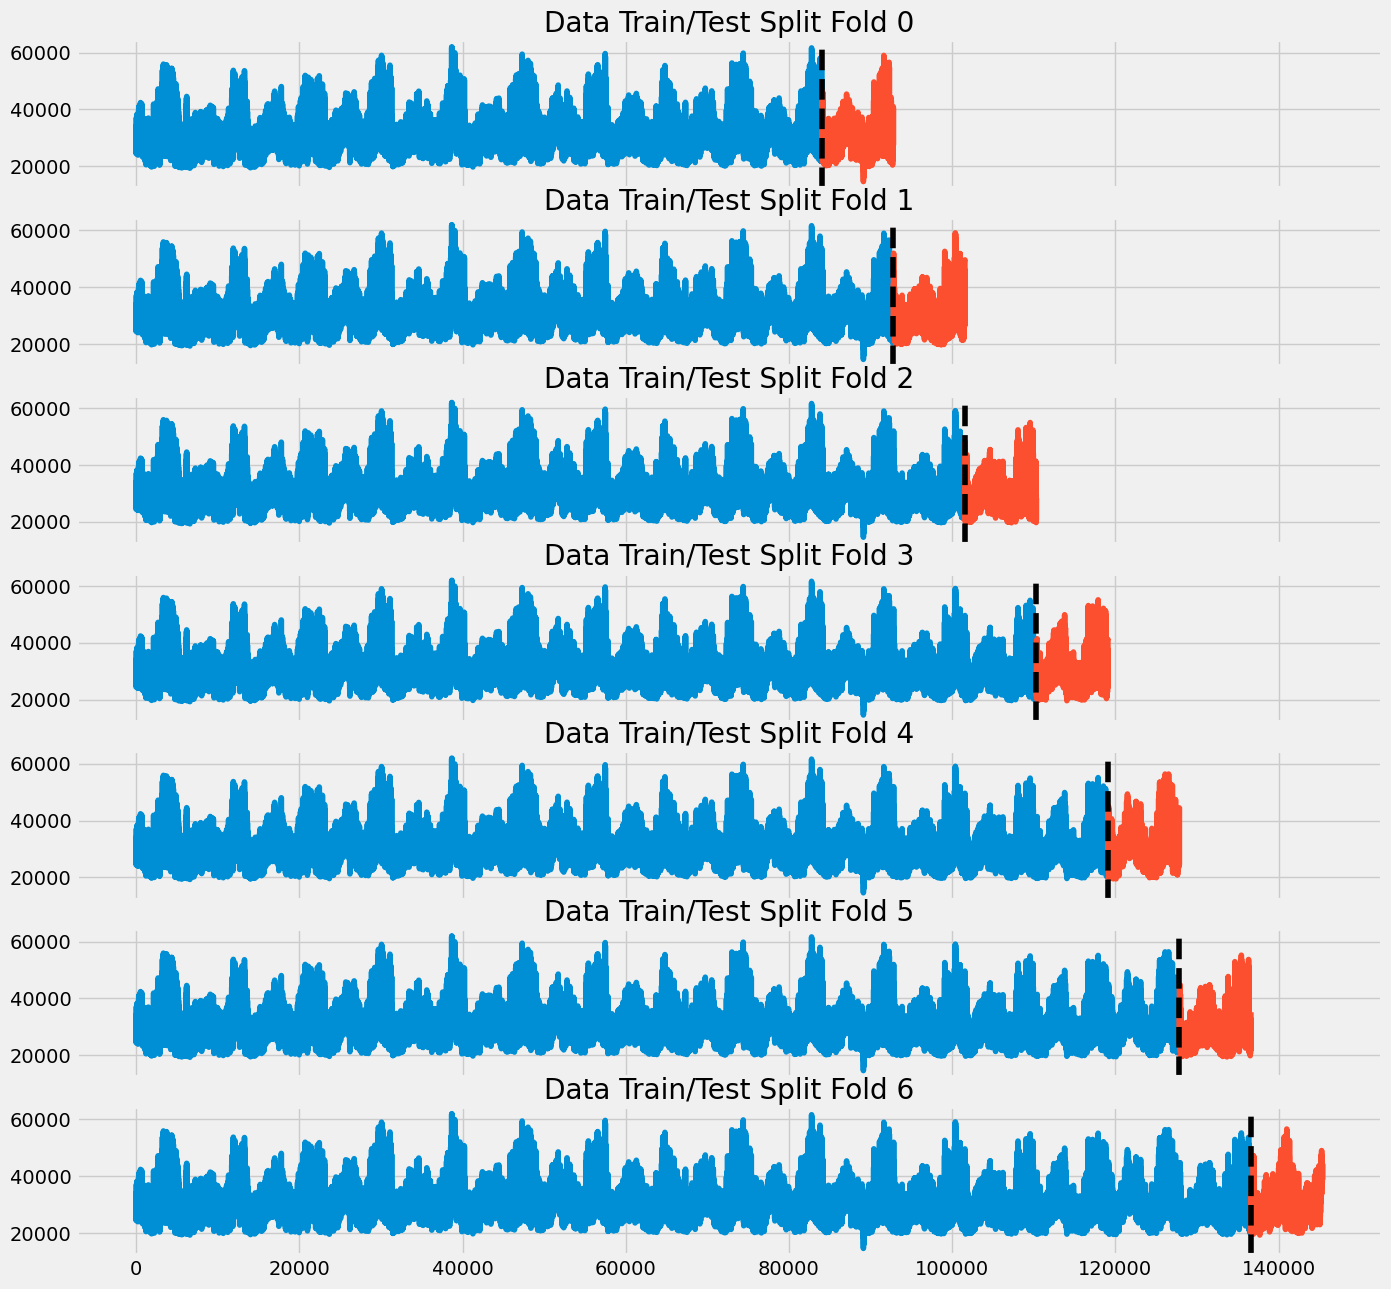

In [34]:
fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df1):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Lags


In [35]:
def add_lags(df):
    # Convert the 'PJME_MW' column to a dictionary for mapping
    target_map = df['PJME_MW'].to_dict()

    df['lag_1_year'] = (df.index - pd.Timedelta('364 days')).map(target_map)

    df['lag_2_years'] = (df.index - pd.Timedelta('728 days')).map(target_map)

    return df

In [36]:
df1 = add_lags(df1)
df1

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_2_years
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0


In [37]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

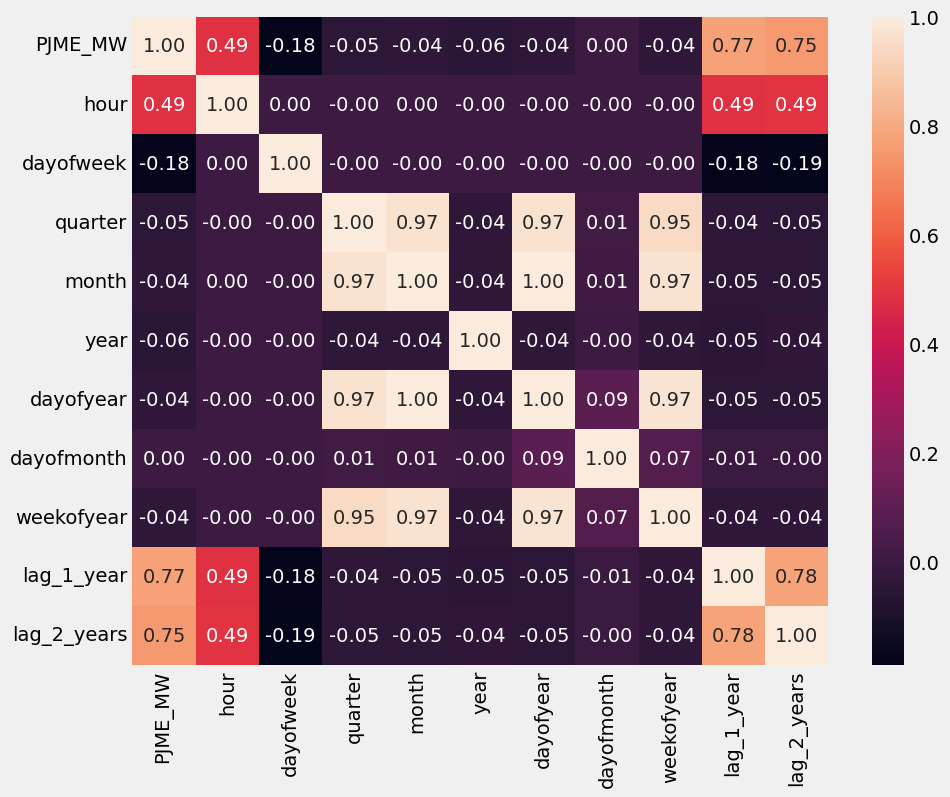

In [38]:
corr_matrix = df1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## XGBoost <a name="5"> </a>

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

In [39]:
tss = TimeSeriesSplit(n_splits=7, test_size=24*365*1, gap=24)
df1 = df1.sort_index()


preds = []
indices = []

rmse_scores = []
mape_scores = []

for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]

    train = add_features(train)
    test = add_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'lag_1_year', 'weekofyear',  'year']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=5,
                           learning_rate=0.05)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)

    preds.extend(y_pred)
    indices.extend(val_idx)

    evals_result = reg.evals_result()


    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)

    rmse_scores.append(rmse_score)
    mape_scores.append(mape_score)

[0]	validation_0-rmse:31587.47707	validation_1-rmse:30380.53793
[100]	validation_0-rmse:2941.80617	validation_1-rmse:3360.46287
[108]	validation_0-rmse:2905.78059	validation_1-rmse:3393.84128
[0]	validation_0-rmse:31480.59093	validation_1-rmse:30805.44051
[100]	validation_0-rmse:2967.46193	validation_1-rmse:3459.61936
[200]	validation_0-rmse:2624.49663	validation_1-rmse:3395.16354
[300]	validation_0-rmse:2462.96024	validation_1-rmse:3327.52980
[400]	validation_0-rmse:2354.29824	validation_1-rmse:3293.94624
[500]	validation_0-rmse:2247.61493	validation_1-rmse:3278.28705
[563]	validation_0-rmse:2189.50091	validation_1-rmse:3275.33563
[0]	validation_0-rmse:31427.46785	validation_1-rmse:30666.43929
[100]	validation_0-rmse:2981.26783	validation_1-rmse:3678.75991
[128]	validation_0-rmse:2855.95040	validation_1-rmse:3687.73919
[0]	validation_0-rmse:31370.02116	validation_1-rmse:30854.12058
[100]	validation_0-rmse:3032.98587	validation_1-rmse:3346.92260
[200]	validation_0-rmse:2713.78435	valid

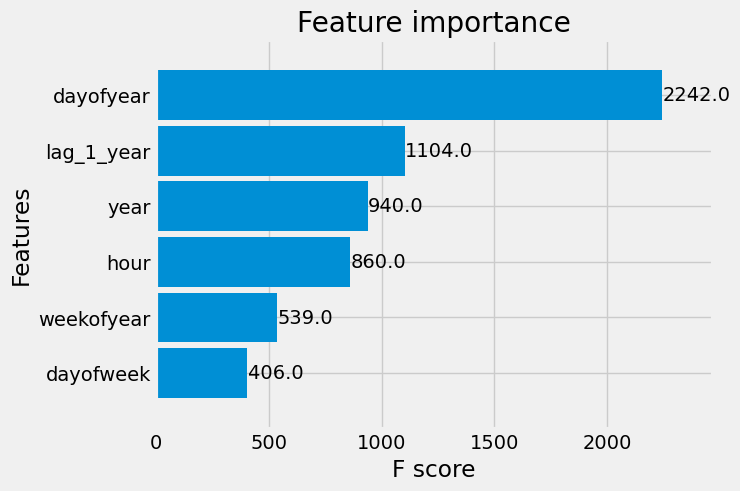

In [40]:
_ = plot_importance(reg, height=0.9)

Visualizing the traning and validation RMSE

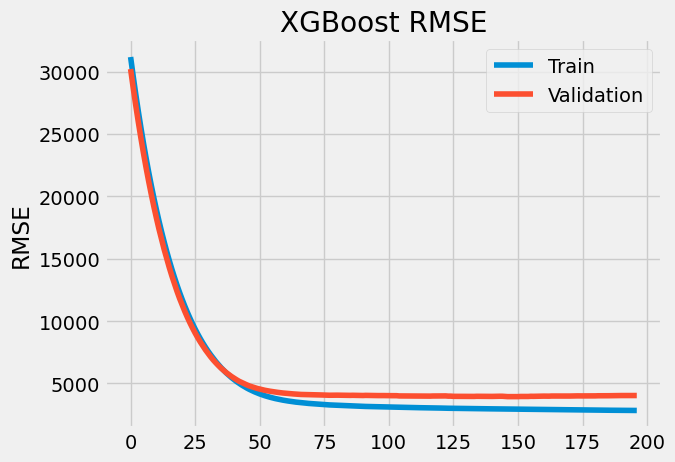

In [41]:
# Extract the rounds
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)


fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation')
ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()


Calculating the RMSE and MAPE errors for each and across all folds

In [42]:
print(f'MAPE Score across folds {np.mean(mape_scores):0.4f}')
print(f'MAPE Fold scores:{mape_scores}')

MAPE Score across folds 7.8724
MAPE Fold scores:[6.434017418686923, 7.551881539525692, 8.244066055407403, 7.303426884154226, 7.884546968310429, 8.619594221560181, 9.069129040698014]


In [43]:
print(f'RMSE Score across folds {np.mean(rmse_scores):0.4f}')
print(f'RMSE Fold scores:{rmse_scores}')

RMSE Score across folds 3462.5338
RMSE Fold scores:[2937.269751166863, 3273.747740883214, 3629.025320113269, 3267.948711383589, 3324.996319860645, 3861.124362379896, 3943.624571291344]


Creating a dataframe with the predictions

In [44]:
preds_df = pd.DataFrame(data=preds, index=df1.iloc[indices].index, columns=['Predicted'])
preds_df

,Predicted
Datetime,
2011-08-04 15:00:00,47138.113281
2011-08-04 16:00:00,47567.062500
2011-08-04 17:00:00,47138.113281
2011-08-04 18:00:00,47138.113281
2011-08-04 19:00:00,46164.167969
...,...
2018-08-02 20:00:00,43563.796875
2018-08-02 21:00:00,42433.257812
2018-08-02 22:00:00,39794.218750


In [45]:
df1['Predicted'] = preds_df['Predicted']
df1

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1_year,lag_2_years,Predicted
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,43563.796875
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,42433.257812
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,39794.218750


Comparing the Actual vs the Predicted PJME_MW

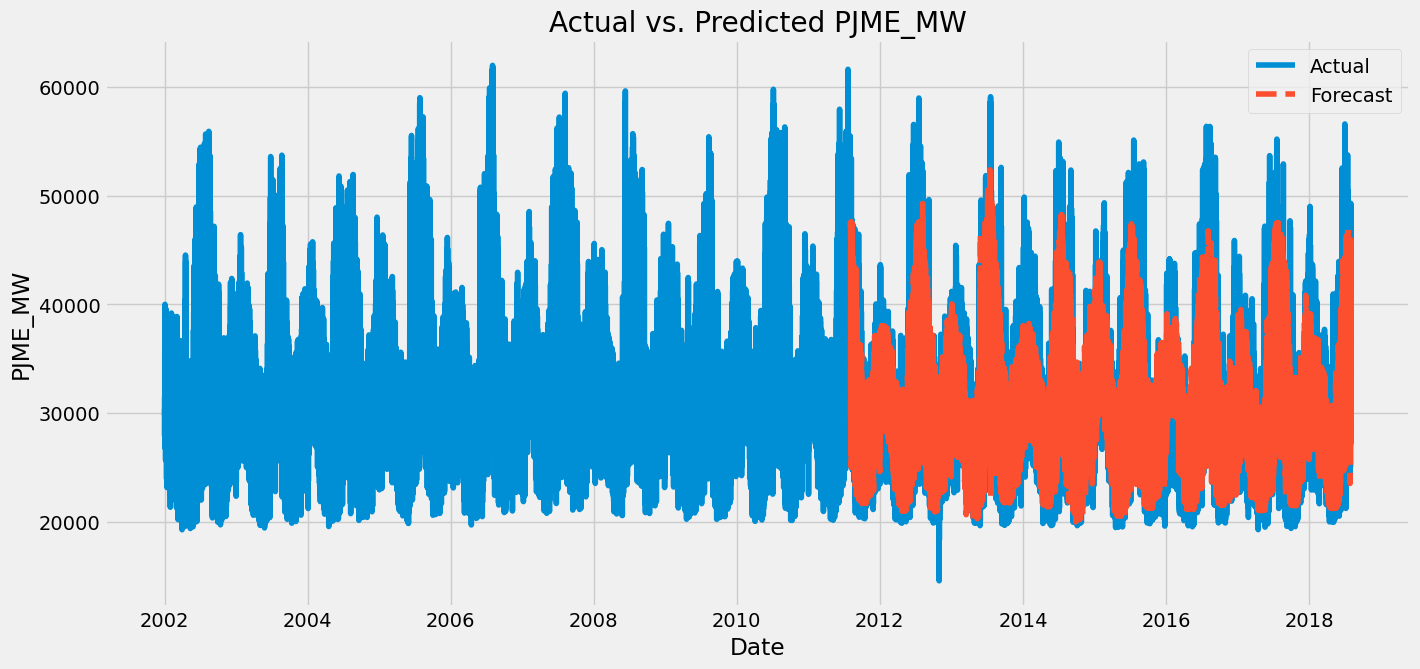

In [46]:
plt.figure(figsize=(15, 7))

# Plot the actual values
plt.plot(df1.index, df1['PJME_MW'], label='Actual')

# Plot the predicted values
plt.plot(df1.index, df1['Predicted'], label='Forecast', linestyle='--')


plt.title('Actual vs. Predicted PJME_MW')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()


plt.show()

Worst Predicted Days

Notice that most of the worst predicted days lie during the summer months.

In [47]:
df1['error'] = df1['PJME_MW'] - df1['Predicted']
df1['abs_error'] = df1['error'].apply(np.abs)
error_by_day = df1.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','Predicted','error','abs_error']]

In [48]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW     Predicted         error     abs_error
year month dayofmonth                                                        
2012 7     21          29097.083333  39625.878906 -10528.794027  10528.794027
2014 7     18          32625.833333  42524.492188  -9898.657715   9898.657715
2017 9     9           24248.208333  33712.433594  -9464.223307   9464.223307
2012 10    30          19769.041667  29049.115234  -9280.071777   9280.071777
2017 9     8           27053.208333  36204.152344  -9150.944499   9150.944499
2014 7     4           29685.375000  38581.984375  -8896.608480   8922.047607
           19          30080.583333  38966.750000  -8886.165609   8886.165609
2012 7     20          33980.250000  42835.804688  -8855.555176   8855.555176
2013 5     27          23873.875000  32648.750000  -8774.874105   8774.874105
2014 7     5           27594.625000  36307.769531  -8713.147135   8713.147135

Best Predicted Days

Notice that most of the best predicted days lie during the fall.

In [50]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,PJME_MW,Predicted,error,abs_error
year,month,dayofmonth,,,,
2014,10,21,27550.958333,27695.814453,-144.857829,220.827067
2016,5,12,26955.833333,26987.337891,-31.506022,244.655273
2015,10,7,27375.041667,27507.767578,-132.727376,265.473145
2017,4,23,23208.541667,23229.570312,-21.027669,267.150716
2016,11,29,29259.333333,29430.023438,-170.691081,267.664551
2014,9,20,26029.250000,26189.257812,-160.007812,296.869792
2015,11,11,27640.000000,27657.462891,-17.464600,304.265055
2016,11,9,27876.666667,28119.109375,-242.441569,311.690918
2014,10,18,24504.750000,24426.728516,78.021240,319.422119
